In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from keras_ocr.detection import Detector

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

SAMPLE_IMG_PATH = './sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


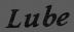

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


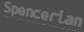

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


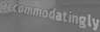

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


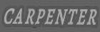

In [2]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [3]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [4]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [5]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [6]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [9]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


실험 진행 시간을 위해 학습은 최초 1회 이후 저장된 모델을 사용하는것으로 하겠습니다.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint와 EarlyStopping 설정
ckp = ModelCheckpoint(filepath='./model_checkpoint.h5', 
                      monitor='val_loss', 
                      save_best_only=True, 
                      save_weights_only=True, 
                      verbose=1)

earlystop = EarlyStopping(monitor='val_loss', 
                          patience=5,  # 성능 향상이 없으면 5번의 epoch 후 멈춤
                          verbose=1, 
                          restore_best_weights=True)
'''
# Model 훈련
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,  # EarlyStopping을 사용하지 않는 경우 최대 20 epochs
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]  # EarlyStopping과 ModelCheckpoint를 적용
)
'''

'\n# Model 훈련\nmodel.fit(train_set,\n          steps_per_epoch=len(train_set),\n          epochs=20,  # EarlyStopping을 사용하지 않는 경우 최대 20 epochs\n          validation_data=val_set,\n          validation_steps=len(val_set),\n          callbacks=[ckp, earlystop]  # EarlyStopping과 ModelCheckpoint를 적용\n)\n'

In [11]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = './model_checkpoint.h5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


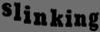

Result: 	 ALEPPO99999999999999999


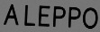

Result: 	 RWANDA999999999999999999


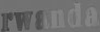

Result: 	 NATHANS99999999999999999


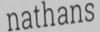

Result: 	 HALOD9999999999999999999


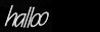

Result: 	 HURLS9999999999999999999


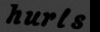

Result: 	 DOWNSIZE9999999999999999


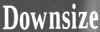

Result: 	 ROBOTIC99999999999999999


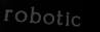

Result: 	 SLOPPY99999999999999999


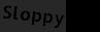

Result: 	 HERMITE99999999999999999


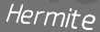

In [12]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [13]:
from PIL import ImageDraw

def detect_text(img_path):
    # 이미지를 로드하고 PIL 형식으로 변환합니다
    img_pil = Image.open(img_path).convert("RGB")
    img = np.array(img_pil)

    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img_batch = np.expand_dims(img, axis=0)

    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detector.detect(img_batch)[0]

    # 이미지를 복사해 시각화를 준비합니다.
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 H 차원으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        # 텍스트 박스 영역을 빨간색으로 그립니다.
        img_draw.polygon(text_result, outline='red')

        # 텍스트 영역의 최소 및 최대 좌표를 계산합니다.
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 텍스트 영역을 잘라냅니다.
        cropped_imgs.append(img_pil.crop(word_box))

    # 결과 이미지를 시각화하고 텍스트 영역 이미지를 반환합니다.
    return result_img, cropped_imgs

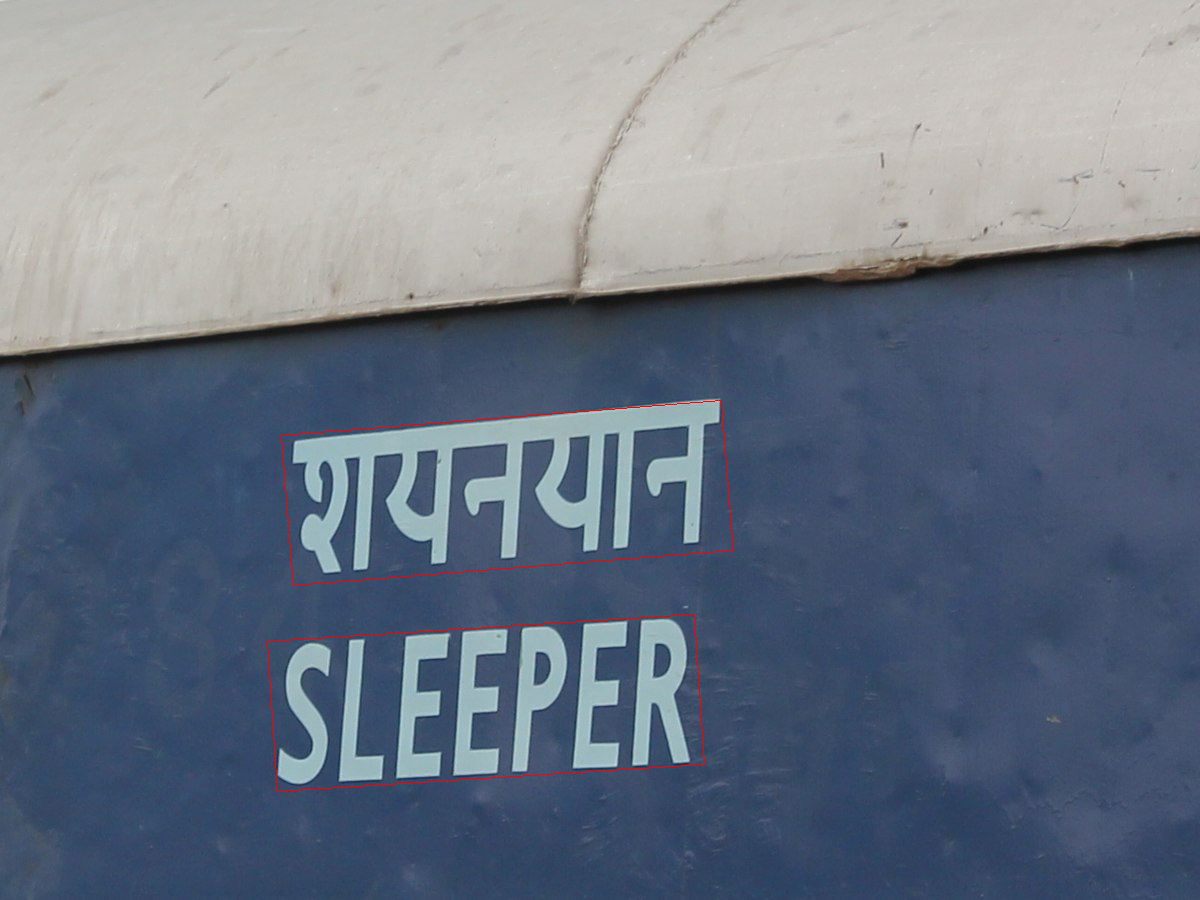

In [14]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [15]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # 이미지를 모델 입력 크기 (100, 32)로 리사이즈하고, RGB 채널로 변환 후, numpy 배열로 변환
    img_array = np.array(pil_img.resize(input_img_size)).transpose(1, 0, 2)
    
    # 모델 예측: 이미지를 배치 크기 1로 변경하여 예측
    output = model_pred.predict(np.expand_dims(img_array, axis=0))
    
    # 예측 결과를 텍스트로 변환하고 출력
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    
    # 이미지를 화면에 표시
    display(Image.fromarray(np.array(pil_img.resize(input_img_size)).astype(np.uint8)))

Result: 	 TRAGRIF99999999999999999


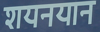

None
Result: 	 SLEEPER9999999999999999


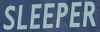

None


In [16]:
for _img in cropped_img:
    print(recognize_img(_img))

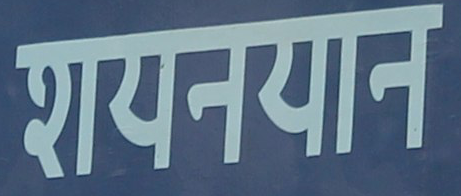

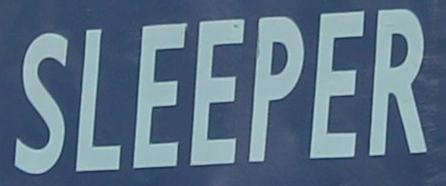

In [17]:
for _img in cropped_img:
    display(_img)

### 회고
- 아랍어로 보이는 부분은 비슷한 형태로 구성된 영어로 변환되었다.
- 영어 sleeper는 비교적 잘 인식 되었다.
- 마지막에 9가 반복적으로 출력되고 있고 ctc디코딩의 문제로 보인다.
- 디코더에서 a~z, 0~9까지를 문자로 인식하는데 9로 출력되는것은 인덱스 문제인지 점검해볼 필요가 있다.
    - TARGET_CHARACTER가 영어 대문자 + 숫자 즉 A-Z, 0-9로 이루어진 배열이다.
    - TARGET_CHARACTER에 ' '를 추가하거나 ''를 마지막에 추가해서 없는 문자를 추가하는것으로 해결할 수 있는지 실험해 볼 필요가 있다.
    - 이 해결책으로 해결되지 않을 때에는 필터링을 통해 9를 없애거나(최악의 방법), 유효 문자 인덱스만 허용하게 하는 방법이 있다.(빈문자의 인덱스를 확인)
    - 빈문자의 예상되는 인덱스는 -1인데 빈문자가 TARGET_CHARACTER에 없으므로 빈문자가 예측될경우 오류를 나타내는 -1이 출력될 것이다.
      
### 1번 해결책 ' '또는 ''추가

In [18]:
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS + ""

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [19]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # 이미지를 모델 입력 크기 (100, 32)로 리사이즈하고, RGB 채널로 변환 후, numpy 배열로 변환
    img_array = np.array(pil_img.resize(input_img_size)).transpose(1, 0, 2)
    
    # 모델 예측: 이미지를 배치 크기 1로 변경하여 예측
    output = model_pred.predict(np.expand_dims(img_array, axis=0))
    
    # 예측 결과를 텍스트로 변환하고 출력
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    
    # 이미지를 화면에 표시
    display(Image.fromarray(np.array(pil_img.resize(input_img_size)).astype(np.uint8)))

Result: 	 TRAGRIF99999999999999999


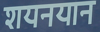

None
Result: 	 SLEEPER9999999999999999


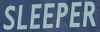

None


In [20]:
for _img in cropped_img:
    print(recognize_img(_img))

""는 실패 이건 안될거라 생각했습니다.

In [21]:
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS + " "

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

Result: 	 TRAGRIF                 


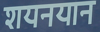

None
Result: 	 SLEEPER                


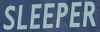

None


In [22]:
for _img in cropped_img:
    print(recognize_img(_img))

In [23]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # 이미지를 모델 입력 크기 (100, 32)로 리사이즈하고, RGB 채널로 변환 후, numpy 배열로 변환
    img_array = np.array(pil_img.resize(input_img_size)).transpose(1, 0, 2)
    
    # 모델 예측: 이미지를 배치 크기 1로 변경하여 예측
    output = model_pred.predict(np.expand_dims(img_array, axis=0))
    
    # 예측 결과를 텍스트로 변환하고 출력
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    # 공백문자 필터링
    result = re.sub(r'\s+', '', result)
    print("Result: \t", result)
    
    # 이미지를 화면에 표시
    display(Image.fromarray(np.array(pil_img.resize(input_img_size)).astype(np.uint8)))

Result: 	 TRAGRIF


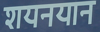

None
Result: 	 SLEEPER


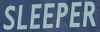

None


In [24]:
for _img in cropped_img:
    print(recognize_img(_img))

### 2번째 방법 인덱스 확인 후 유효 인덱스만 출력
- 위의 공백을 넣는 방법으로 확인된 것은 무조건 가장 마지막 인덱스가 빈 문자일경우 선택된다는 점입니다.
    - 이런 경우는 인덱스가 -1로 언더플로우 현상이 발생했을경우 단 하나뿐으로 생각됩니다.
    - 여전히 인식할 수 없는 오류값 -1이 빈문자의 경우 출력된다는 뜻으로 보입니다.(통상적으로 오류값일 경우 함수의 출력이 -1)
    - 공백문자를 TARGET_CHARACTER에 추가한 위 방법에서 공백문자를 필터링하는 방법도 사용할 수 있습니다.
    - 처음부터 유효 인덱스만 출력하도록 해보겠습니다.

In [25]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index!=-1:
            text += chars[index]
    results.append(text)
    return results

Result: 	 TRAGRIF


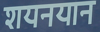

None
Result: 	 SLEEPER


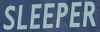

None


In [26]:
for _img in cropped_img:
    print(recognize_img(_img))

변경 전
```python
    for index in indexes:
        text += chars[index]
```  
  
변경 후
```python
    for index in indexes:
        if index!=-1:
            text += chars[index]
```

- 위의 변경으로 뒤의 공백도 출력되지 않게 작성되었습니다. 인덱스를 확인하는 과정은 추론을 통해 넘어갔지만 조건문을 !=-1 로 사용함으로써 잘못된 문자는 -1의 인덱스를 갖는다는 사실을 확인할 수 있습니다.  

### 추가 실험
- 다른 이미지의 경우도 실험해보고 이미지에 노이즈가 있을 경우도 실험해 봅니다.

In [27]:
SAMPLE_IMG_PATH_1 = './sample1.jpg'
SAMPLE_IMG_PATH_2 = './sample2.jpg'
SAMPLE_IMG_PATH_3 = './sample3.jpg'

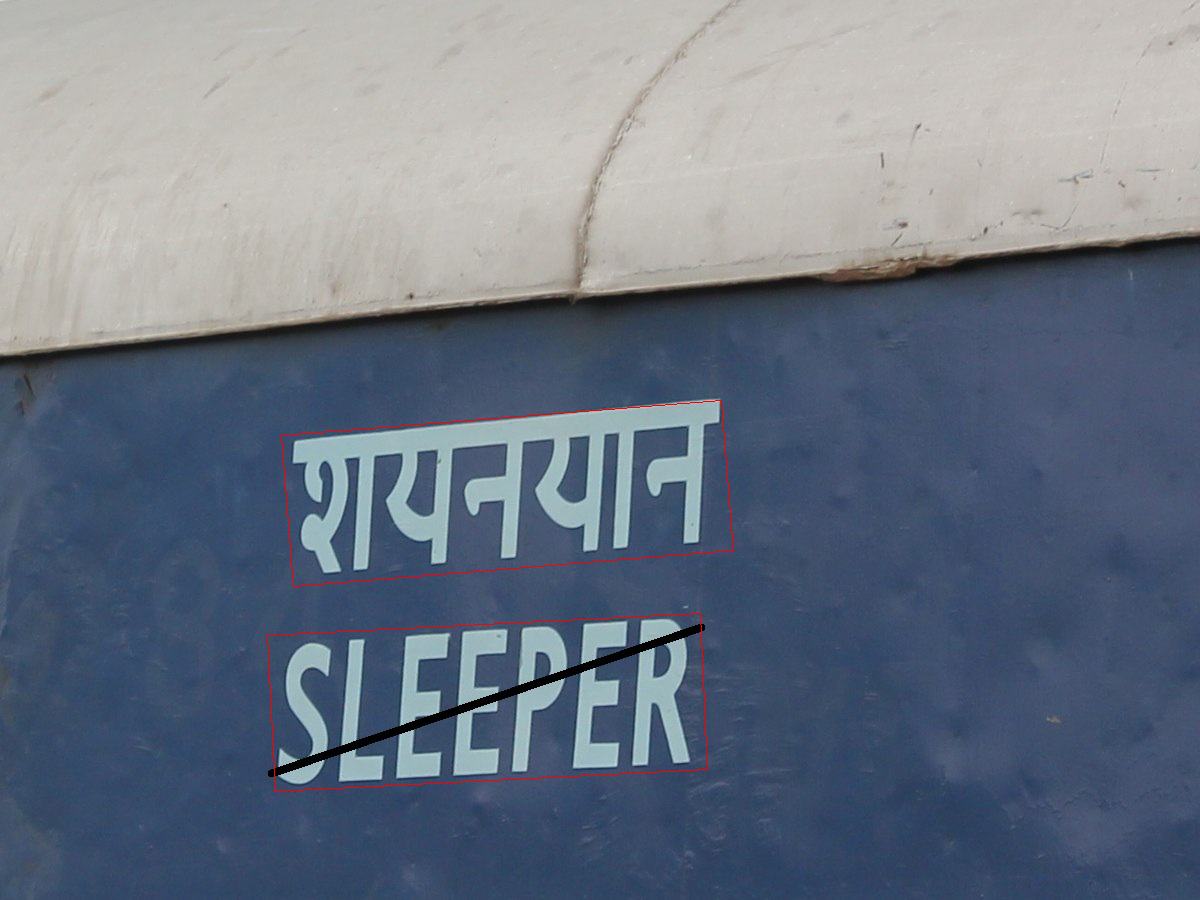

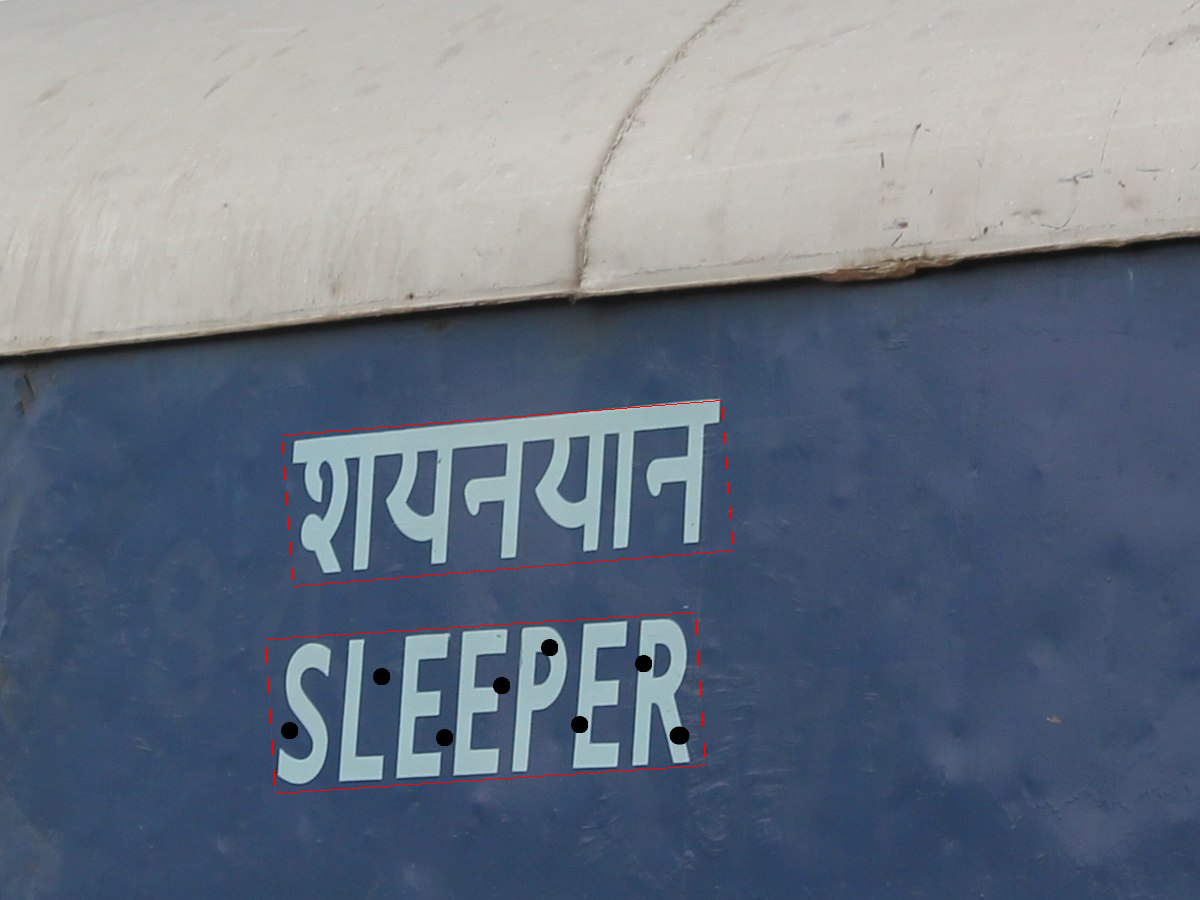

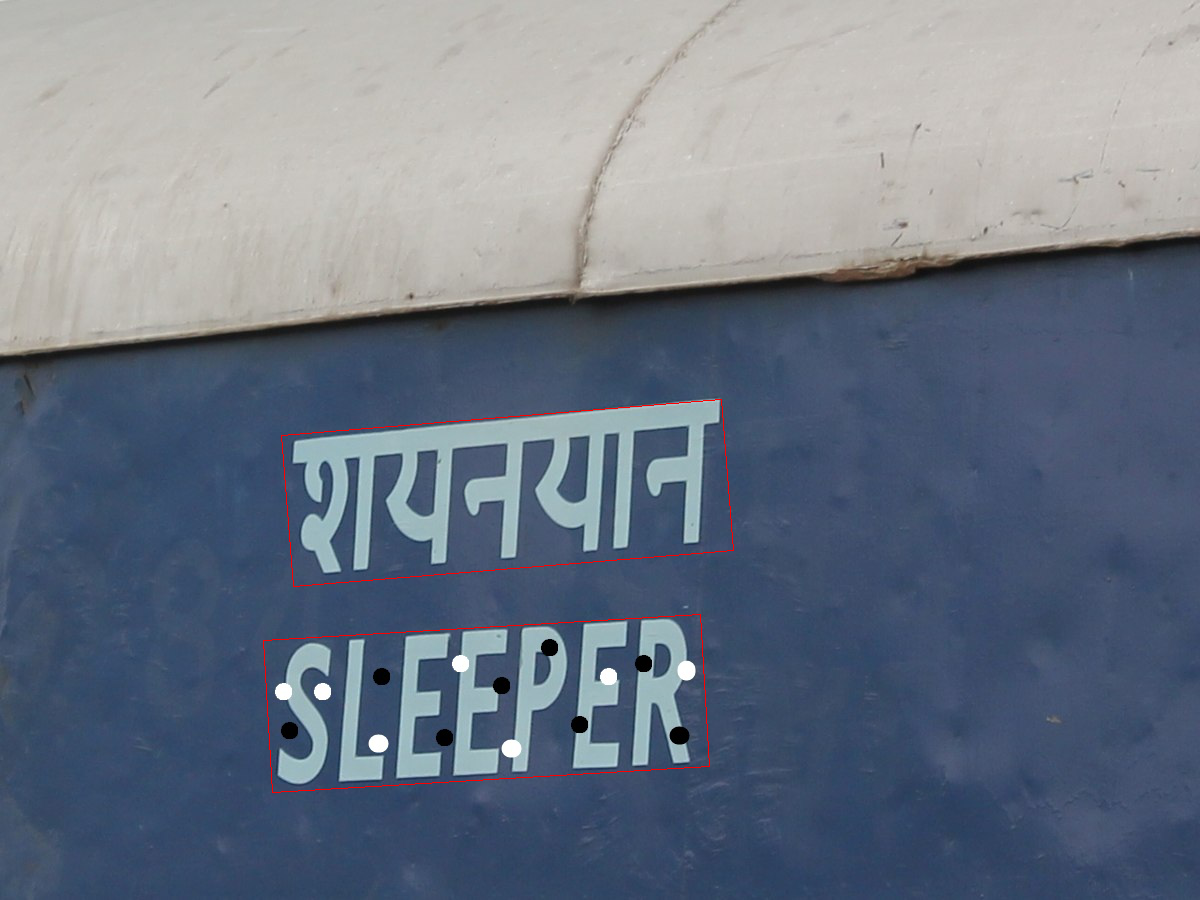

In [28]:
img_pil1, cropped_img1 = detect_text(SAMPLE_IMG_PATH_1)
display(img_pil1)
img_pil2, cropped_img2 = detect_text(SAMPLE_IMG_PATH_2)
display(img_pil2)
img_pil3, cropped_img3 = detect_text(SAMPLE_IMG_PATH_3)
display(img_pil3)

Result: 	 TRGRIF


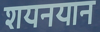

None
Result: 	 SLERER


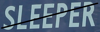

None
Result: 	 TRAGRIF


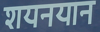

None
Result: 	 SHEEPER


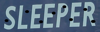

None
Result: 	 TRGRIF


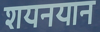

None
Result: 	 SLEEPIT


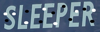

None


In [29]:
for _img in cropped_img1:
    print(recognize_img(_img))
    
for _img in cropped_img2:
    print(recognize_img(_img))

for _img in cropped_img3:
    print(recognize_img(_img))

### 노이즈 추가 실험 회고
- 각각의 경우에 대해서
    - 사선을 그은 경우 2개의 E가 하나로 합처졌다. 하나의 E만 인식된것으로 추정된다.
    - 검은 점을 추가한 경우 L이 H로 인식되었다.
    - 흰 점과 검은 점이 모두있는 경우에서는 E와 R이 다른 문자로 인식되었다. 검은 점 위치는 그대로인데도 불구하고 이전의 경우와 다르게 L은 그대로 L로 인식되었다. 흰 점이 검은 점의 구간의 특성맵의 활성화를 막는 역할을 한것으로 보인다.
    - E의 중앙 가로선에 흰점이 위치하여 i로 인식되었는데 이전의 L의 경우에서 생각했던 흰점이 해당 부분의 활성화를 막는 역할을 한다면 E가 ㄷ모양으로 형성되어서 i로 예측됐다고 생각해 볼 수 있을거 같다.
    - R에서도 위쪽 도넛모양의 곡선 오른쪽에 흰점이 위치하여 선을 끊는 역할을 했다면 가장 비슷한 알파벳은 T로 보이고 그리하여 T로 예측된 거 같다.
    - 글자는 연한색 배경은 짙은색인 이미지인데 어째서 검은 점은 특성을 활성화하고 흰점은 비활성화하는지 구체적인 이유를 찾기가 힘들다.
        - 단편적으로 생각했을 때 주로 흰것은 배경 검은것은 글자라는 말에 의거하여 보편적으로 검정색이 글자인 경우가 많고 이를 학습한 모델에서 비록 글자가 밝은 색이더라도 검은점도 글자의 일부분으로 인식한 것이 아닌가 생각해 볼 수 있다.

### 추가 실험 2
- 글자체가 다른 이미지

In [30]:
SAMPLE_IMG_PATH_4 = './sample4.jpg'

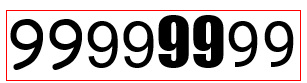

In [31]:
img_pil4, cropped_img4 = detect_text(SAMPLE_IMG_PATH_4)
display(img_pil4)

Result: 	 GOIIG


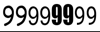

None


In [32]:
for _img in cropped_img4:
    print(recognize_img(_img))

### 글자체 추가 실험 회고
- 글자체가 서로 다른 9로 실험해 봤을 때 예측 결과가 좋지않았다.
- 글자체가 달라지는 경우 9라고 예측을 성공하지도 못했고 같은 글자로 예측해 내지도 못했다.
- 손글씨일때 성능을 기대하기 힘들거 같다.